# Testing KeyFinder class

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
import warnings

warnings.filterwarnings('ignore')
np.seterr(all='ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from image_reader import get_images
from key_finder import KeyFinder

In [3]:
train_loader, test_loader = get_images()

Found 520 images


100%|██████████| 520/520 [01:11<00:00,  7.26it/s]


ELO
False
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) inst

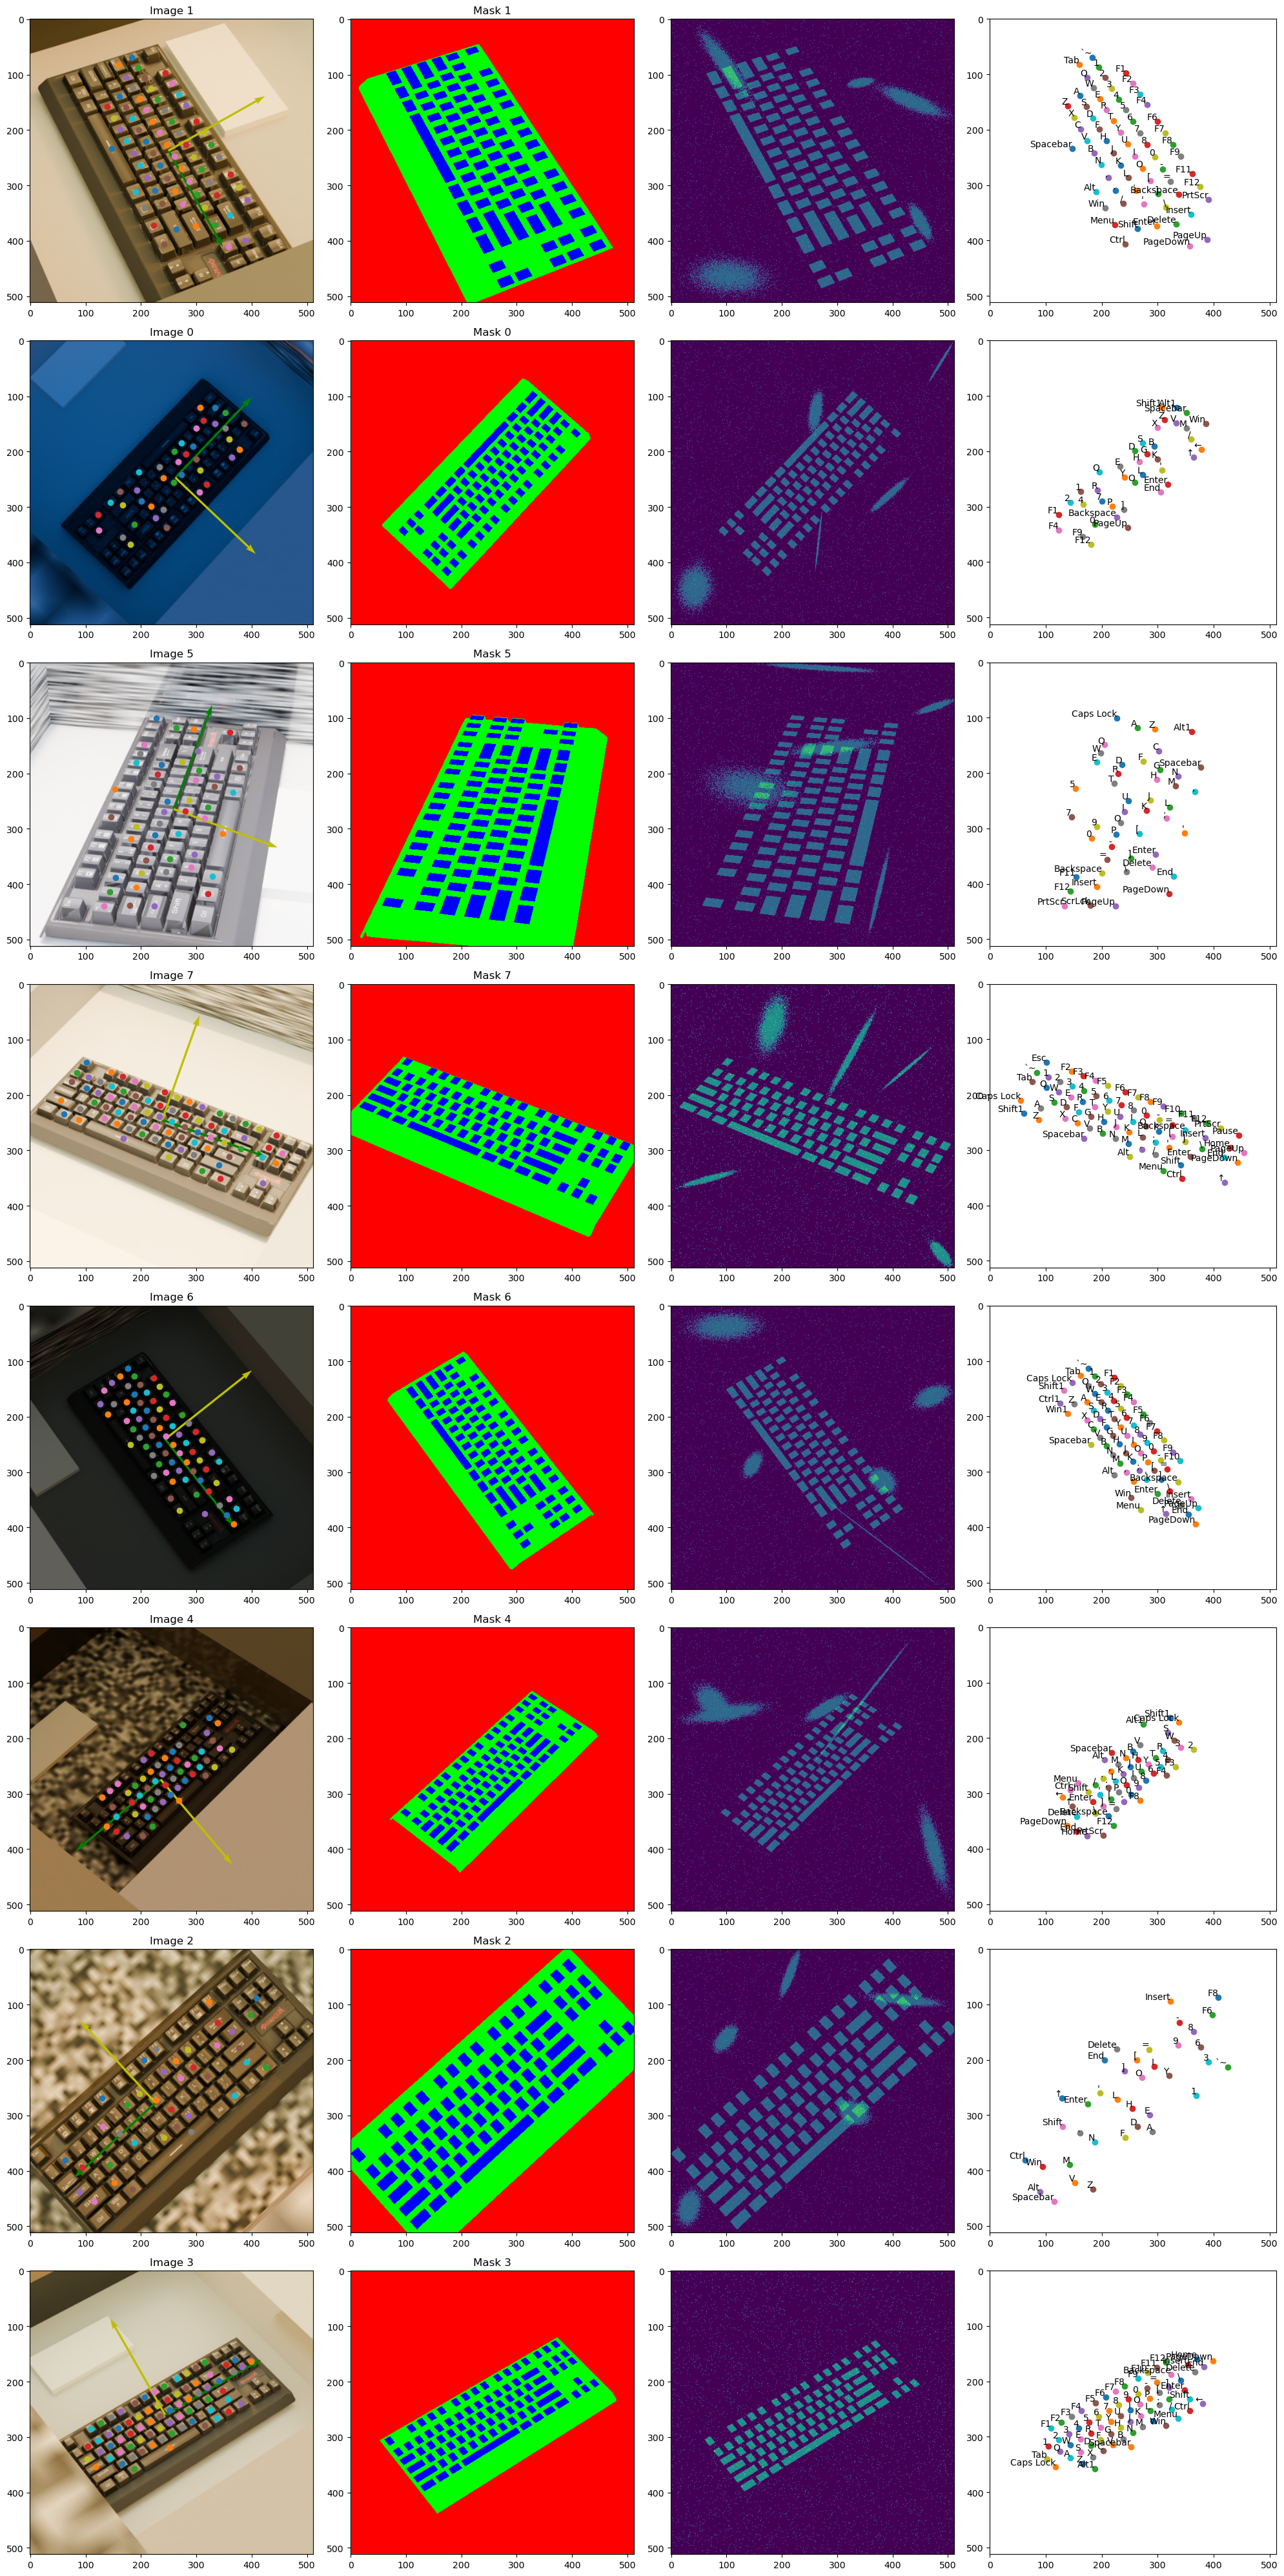

In [23]:
fig, axes = plt.subplots(8, 4, figsize=(20, 40))
img_size = 512
n_samples = 50000
n_blobs = 5

for i, (img, mask) in enumerate(train_loader):
    indices = np.random.choice(img.size(0), 8, replace=False)
    for j, idx in enumerate(indices):
        axes[j, 0].imshow(img[idx].permute(1, 2, 0))
        axes[j, 0].set_title(f'Image {idx}')
        axes[j, 1].imshow(mask[idx].permute(1, 2, 0))
        axes[j, 1].set_title(f'Mask {idx}')

        keys = mask[idx][2,:].numpy().astype(np.uint8)
        
        noise = np.zeros_like(keys)
        ones_indices = np.random.choice(np.arange(keys.size), size=5000, replace=False)
        noise.flat[ones_indices] = 1
        keys = keys + noise

        X, labels = make_blobs(n_samples=n_samples, centers=n_blobs, cluster_std=20, center_box=(0, img_size))
        X_transformed = np.zeros_like(X)
        for i in range(n_blobs):
            transformation_matrix = np.random.randn(2, 2) * 2 
            X_transformed[labels == i] = X[labels == i] @ transformation_matrix

        X_min, X_max = X_transformed.min(axis=0), X_transformed.max(axis=0)
        X_transformed = (X_transformed - X_min) / (X_max - X_min) * img_size 

        X_transformed = np.clip(X_transformed, 0, img_size - 1).astype(int)
        image = np.zeros((img_size, img_size), dtype=np.uint8)

        for x, y in X_transformed:
            image[y, x] = 1  

        keys = keys + image if j <7 else keys

        axes[j,2].imshow(keys)

        try:
            kf = KeyFinder(min_keys=50, 
                           probability_threshold=0.8,
                           min_key_size=100,
                           key_displacement_distance=1e-2,
                           input_missing_keys=False,
                           use_gauss=False,
                           max_cluster_size=90,
                           check_space_eccentricity= True,
                           min_eccentricity = 0.2,
                           cluster_epsilon=np.inf)
            letters = kf.find(keys)
            middle_x, middle_y = np.mean(kf.centers[:, 0]), np.mean(kf.centers[:, 1])
            axes[j, 0].quiver([middle_x, middle_x], 
                              [middle_y, middle_y], 
                              [200*vec[0] for vec in kf.base2], 
                              [200*vec[1] for vec in kf.base2], 
                              color=['g', 'y'], scale=1, scale_units='xy', angles='xy')
        except Exception as e:
            print(e)
            continue

        rotate = 1
        for key, value in letters.items():
            x, y = value['coords'][0,0], value['coords'][0,1] 
            x = x*(kf.return_values[1] - kf.return_values[0]) + kf.return_values[0] 
            y = y*(kf.return_values[3] - kf.return_values[2]) + kf.return_values[2] 
            coords = np.matrix([x,y])
            inverse = np.transpose(np.matrix(kf.base2))
            coords = np.matmul(coords, inverse)
            
            x = coords[0,0] + np.mean(kf.centers[:,0])
            y = coords[0,1] + np.mean(kf.centers[:,1])
            x = x+ int(x<0)*img_size
            y = y+ int(y<0)*img_size
            
            axes[j,3].scatter(x, y, label=key) 
            axes[j,0].scatter(x, y, label=key)  
            axes[j,3].text(x, y, key, fontsize=10, ha='right', va='bottom')
            axes[j,3].set_xlim([0,img_size])
            axes[j,3].set_ylim([0,img_size])
            axes[j,3].invert_yaxis()
        print("Rotate",j,":", rotate)
    break

plt.tight_layout()
plt.show()